In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return beta * torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

beta = 0.1

kl_weight = 128/len(trainset)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(30):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kl_weight * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.16it/s]


Epoch: 0 - TrainRecLoss: 213.03721680468334 - ValidRecLoss: 182.0171358132664
Epoch: 0 - TrainDivLoss: 7.346281459790343 - ValidDivLoss: 12.630864740927008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.26it/s]


Epoch: 1 - TrainRecLoss: 178.2781971034719 - ValidRecLoss: 173.74549885037578
Epoch: 1 - TrainDivLoss: 13.187324796404157 - ValidDivLoss: 11.558633055868029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.45it/s]


Epoch: 2 - TrainRecLoss: 172.05826915098405 - ValidRecLoss: 169.2475713415991
Epoch: 2 - TrainDivLoss: 10.340798660636203 - ValidDivLoss: 10.023063816601717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.43it/s]


Epoch: 3 - TrainRecLoss: 169.10728178044627 - ValidRecLoss: 167.4013772312599
Epoch: 3 - TrainDivLoss: 9.028575958219418 - ValidDivLoss: 8.60422345656383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.21it/s]


Epoch: 4 - TrainRecLoss: 167.41548810686385 - ValidRecLoss: 166.18365826184237
Epoch: 4 - TrainDivLoss: 8.278030691370526 - ValidDivLoss: 8.211046037794668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.93it/s]


Epoch: 5 - TrainRecLoss: 166.24128791467467 - ValidRecLoss: 165.3430614229999
Epoch: 5 - TrainDivLoss: 7.709963632799161 - ValidDivLoss: 7.037430874909027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.75it/s]


Epoch: 6 - TrainRecLoss: 165.15395883913996 - ValidRecLoss: 164.0504743358757
Epoch: 6 - TrainDivLoss: 7.28757758333739 - ValidDivLoss: 7.384983759892138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.84it/s]


Epoch: 7 - TrainRecLoss: 164.14197099437592 - ValidRecLoss: 162.60221901422815
Epoch: 7 - TrainDivLoss: 6.924110427848311 - ValidDivLoss: 7.046637130689017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.95it/s]


Epoch: 8 - TrainRecLoss: 162.8550774222498 - ValidRecLoss: 161.61974885192097
Epoch: 8 - TrainDivLoss: 6.652787780965061 - ValidDivLoss: 6.4982777275616606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.15it/s]


Epoch: 9 - TrainRecLoss: 161.41440105641576 - ValidRecLoss: 160.46905324428897
Epoch: 9 - TrainDivLoss: 6.400849105452678 - ValidDivLoss: 6.525175658962395


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.00it/s]


Epoch: 10 - TrainRecLoss: 159.57109997064066 - ValidRecLoss: 158.08268254919898
Epoch: 10 - TrainDivLoss: 6.445491079074233 - ValidDivLoss: 6.360017329831667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.16it/s]


Epoch: 11 - TrainRecLoss: 157.91904747155684 - ValidRecLoss: 156.70625652844393
Epoch: 11 - TrainDivLoss: 6.6181960726089315 - ValidDivLoss: 6.5114451420458055


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.91it/s]


Epoch: 12 - TrainRecLoss: 156.49087199066747 - ValidRecLoss: 155.3321977446351
Epoch: 12 - TrainDivLoss: 6.721446849644057 - ValidDivLoss: 6.615508399432218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.04it/s]


Epoch: 13 - TrainRecLoss: 155.36651614581598 - ValidRecLoss: 154.32993944385385
Epoch: 13 - TrainDivLoss: 6.793884268193357 - ValidDivLoss: 6.691283141510396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.20it/s]


Epoch: 14 - TrainRecLoss: 154.46165394732185 - ValidRecLoss: 153.55105861229234
Epoch: 14 - TrainDivLoss: 6.819715605615807 - ValidDivLoss: 6.999789020683192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.13it/s]


Epoch: 15 - TrainRecLoss: 153.6717624298291 - ValidRecLoss: 153.36769683451593
Epoch: 15 - TrainDivLoss: 6.814576764096583 - ValidDivLoss: 6.912865167931665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.88it/s]


Epoch: 16 - TrainRecLoss: 152.959113895766 - ValidRecLoss: 152.16095492206043
Epoch: 16 - TrainDivLoss: 6.822840156839855 - ValidDivLoss: 6.888392744185049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.21it/s]


Epoch: 17 - TrainRecLoss: 152.50429175403326 - ValidRecLoss: 151.7636772831784
Epoch: 17 - TrainDivLoss: 6.800720957042312 - ValidDivLoss: 6.773210139214238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.08it/s]


Epoch: 18 - TrainRecLoss: 151.9214117379585 - ValidRecLoss: 151.64157220381725
Epoch: 18 - TrainDivLoss: 6.865333353786834 - ValidDivLoss: 7.025933410547957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.96it/s]


Epoch: 19 - TrainRecLoss: 151.42051469034223 - ValidRecLoss: 150.62286801881427
Epoch: 19 - TrainDivLoss: 6.877066715948109 - ValidDivLoss: 6.873006247266939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.92it/s]


Epoch: 20 - TrainRecLoss: 151.07858406506114 - ValidRecLoss: 150.7629854226414
Epoch: 20 - TrainDivLoss: 6.825325166747006 - ValidDivLoss: 6.796238561219807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.21it/s]


Epoch: 21 - TrainRecLoss: 150.67907008840078 - ValidRecLoss: 150.22908039334453
Epoch: 21 - TrainDivLoss: 6.858316261885263 - ValidDivLoss: 6.904619947264466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.16it/s]


Epoch: 22 - TrainRecLoss: 150.28093659293168 - ValidRecLoss: 149.93566933161097
Epoch: 22 - TrainDivLoss: 6.864510609396993 - ValidDivLoss: 6.818806304207331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.24it/s]


Epoch: 23 - TrainRecLoss: 149.91941472360574 - ValidRecLoss: 149.42157870908326
Epoch: 23 - TrainDivLoss: 6.928606767390074 - ValidDivLoss: 6.797364536719986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.03it/s]


Epoch: 24 - TrainRecLoss: 149.78656077435784 - ValidRecLoss: 149.4787354288222
Epoch: 24 - TrainDivLoss: 6.911181004571 - ValidDivLoss: 6.888968769508072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.10it/s]


Epoch: 25 - TrainRecLoss: 149.3474574627907 - ValidRecLoss: 149.33035973657536
Epoch: 25 - TrainDivLoss: 6.969414856388116 - ValidDivLoss: 6.912225427506845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.23it/s]


Epoch: 26 - TrainRecLoss: 149.08392961904693 - ValidRecLoss: 148.70559557178353
Epoch: 26 - TrainDivLoss: 7.012154589329701 - ValidDivLoss: 7.017866780486288


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.56it/s]


Epoch: 27 - TrainRecLoss: 148.91242584033307 - ValidRecLoss: 148.68291425101364
Epoch: 27 - TrainDivLoss: 6.963776262075917 - ValidDivLoss: 7.016066454633882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.97it/s]


Epoch: 28 - TrainRecLoss: 148.61392094789028 - ValidRecLoss: 149.35597982285898
Epoch: 28 - TrainDivLoss: 6.998434124724952 - ValidDivLoss: 7.165019566499734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.99it/s]

Epoch: 29 - TrainRecLoss: 148.33511811278777 - ValidRecLoss: 148.82759248757665
Epoch: 29 - TrainDivLoss: 7.012266967342352 - ValidDivLoss: 7.0044203227079365


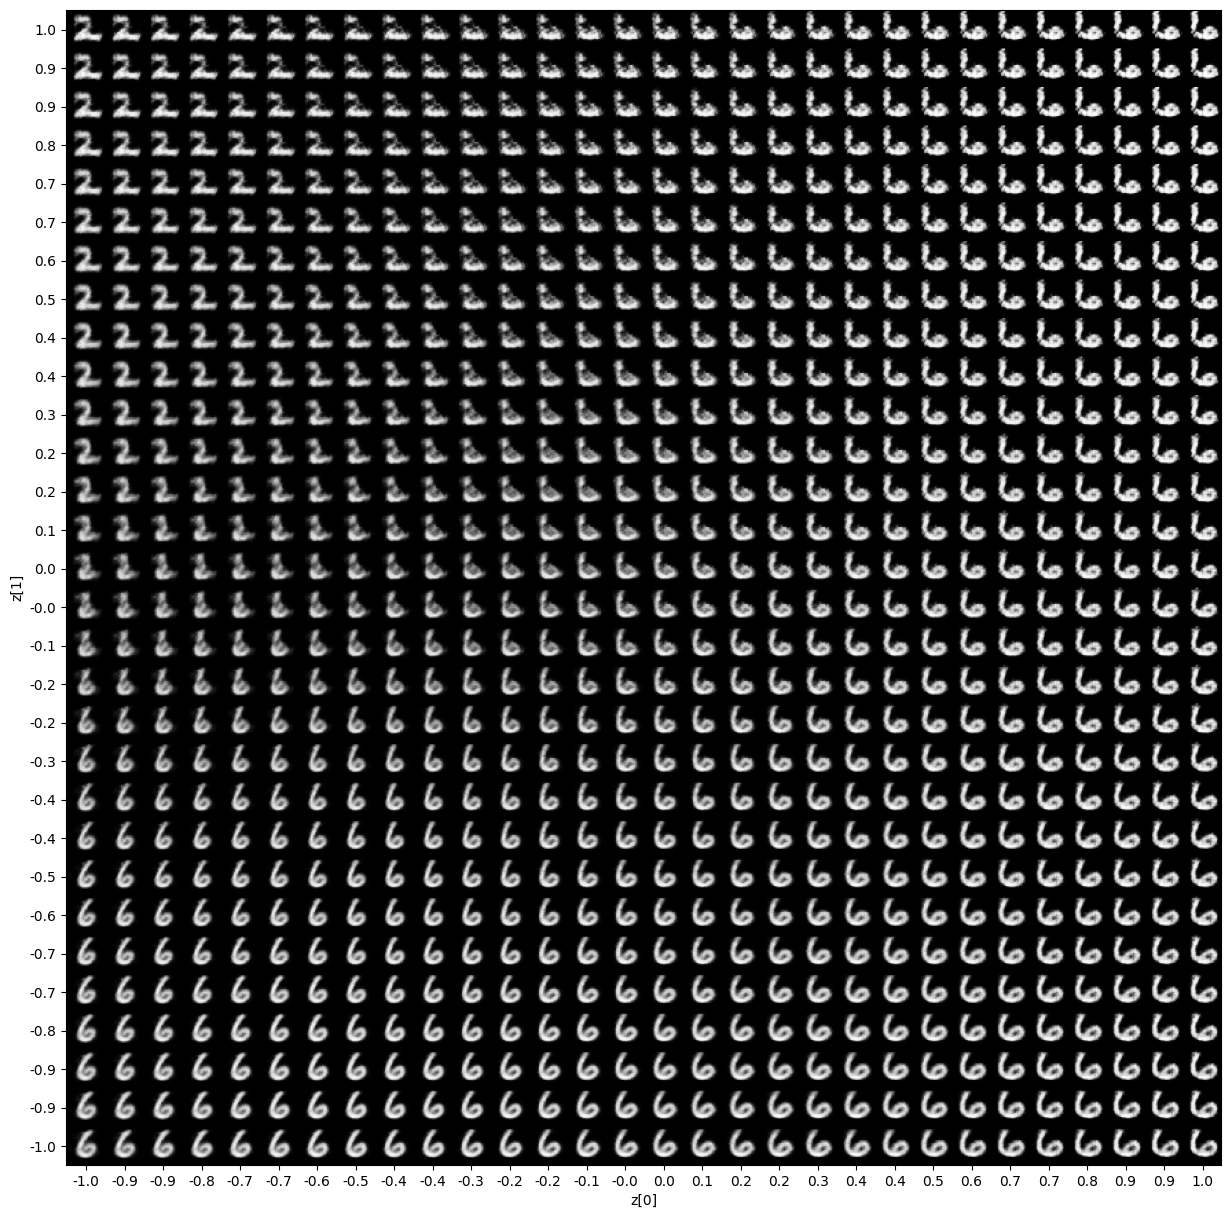

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()